In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp
import tensorflow as tf
from uitils import *
# from uitils import bin_ploter
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, recall_score, f1_score, confusion_matrix


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import lightgbm as lgb
print('GPU support:', lgb.LGBMClassifier(device='gpu').get_params()['device'])



Num GPUs Available:  1
GPU support: gpu


# Data Loading

In [3]:
import numpy as np
from keras.datasets import mnist
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Function to extract samples from the dataset
def extract_samples(x, y, num_samples):
    indices = np.random.choice(x.shape[0], num_samples, replace=False)
    return x[indices], y[indices]

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, y_train = extract_samples(x_train, y_train, 500)
# x_test, y_test = extract_samples(x_test, y_test, 100)
print("Reduced training set shape:", x_train.shape)
print("Reduced testing set shape:", x_test.shape)

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the images for LightGBM
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Convert labels to 0 (even) and 1 (odd)
y_train = y_train % 2
y_test = y_test % 2

# Initialize 's' to zeros, meaning initially all are unlabeled
s = np.zeros_like(y_train)

# Select a random 1000 samples where y_train == 1 to be labeled
positive_indices = np.where(y_train == 1)[0]
chosen_indices = np.random.choice(positive_indices, size=1000)

# Mark these as labeled in 's'
s[chosen_indices] = 1

# Mark the rest of the positive_indices except the chosen 1000 as potential targets for unlabeled marking
rest_of_positives = np.setdiff1d(positive_indices, chosen_indices)

# From the rest, select 3% and mark their labels as 0 in y_train
number_to_mark_unlabeled = int(len(rest_of_positives) * 0.03)
unlabeled_indices = np.random.choice(rest_of_positives, size=number_to_mark_unlabeled)
y_train[unlabeled_indices] = 0

# Remove the rest of the positive rows that are not in the chosen 1000 and not marked as unlabeled
indices_to_drop = np.setdiff1d(rest_of_positives, np.concatenate([chosen_indices, unlabeled_indices]))
x_train = np.delete(x_train, indices_to_drop, axis=0)
y_train = np.delete(y_train, indices_to_drop)
s = np.delete(s, indices_to_drop)

print("Training labels distribution:", np.bincount(y_train))
print("Training original labels distribution:", np.bincount(s))


Reduced training set shape: (60000, 28, 28)
Reduced testing set shape: (10000, 28, 28)
Training labels distribution: [30367   980]
Training original labels distribution: [30367   980]


In [4]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, y_train = extract_samples(x_train, y_train, 500)
# x_test, y_test = extract_samples(x_test, y_test, 100)
# print("Reduced training set shape:", x_train.shape)
# print("Reduced testing set shape:", x_test.shape)
# x_train = x_train / 255.0
# x_test = x_test / 255.0
# y_train = y_train % 2  # Convert labels to 0 (even) and 1 (odd) 
# y_test = y_test % 2
# s=y_train

# # Initialize 's' to zeros, meaning initially all are unlabeled
# s = np.zeros_like(y_train)

# # Select a random 300 samples where y_train == 1 to be labeled
# positive_indices = np.where(y_train == 1)[0]
# chosen_indices = np.random.choice(positive_indices, size=1000, replace=False)

# # Mark these as labeled in 's'
# s[chosen_indices] = 1

# # Mark the rest of the positive_indices except the chosen 300 as potential targets for unlabeled marking
# rest_of_positives = np.setdiff1d(positive_indices, chosen_indices)

# # From the rest, select 30% and mark their labels as 0 in y_train
# number_to_mark_unlabeled = int(len(rest_of_positives) * 0.03)
# # number_to_mark_unlabeled = int(1)
# unlabeled_indices = np.random.choice(rest_of_positives, size=number_to_mark_unlabeled, replace=False)
# y_train[unlabeled_indices] = 0

# # Remove the rest of the positive rows that are not in the chosen 300 and not marked as unlabeled
# indices_to_drop = np.setdiff1d(rest_of_positives, np.concatenate([chosen_indices, unlabeled_indices]))
# x_train = np.delete(x_train, indices_to_drop, axis=0)
# y_train = np.delete(y_train, indices_to_drop)
# s = np.delete(s, indices_to_drop)

# print("Training labels distribution:", np.bincount(y_train))
# print("Training original labels distribution:", np.bincount(s))

In [5]:
y_test

array([1, 0, 1, ..., 0, 1, 0], dtype=uint8)

# Pre-training

In [6]:
# Import LightGBM and necessary libraries
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Create LightGBM datasets
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)

# Set the parameters for LightGBM
params = {
    'boosting_type': 'gbdt',        # Gradient boosting decision tree
    'objective': 'binary',          # Binary classification
    'metric': 'binary_logloss',     # Evaluation metric
    'num_leaves': 31,               # Number of leaves in full tree
    'learning_rate': 0.01,          # Learning rate
    'feature_fraction': 0.9,        # Fraction of features to be used at each iteration
    'bagging_fraction': 0.8,        # Fraction of data to be used for each iteration
    'bagging_freq': 5,              # Frequency for bagging
    'device': 'gpu',                # Use GPU for training
    'verbose': 1                    # Verbose output
}

# Number of boosting rounds
num_boost_round = 100

# Train the LightGBM model
model_lgb = lgb.train(params, train_data, num_boost_round=num_boost_round, valid_sets=[test_data])

# Save the model
model_lgb.save_model('lgb_model_mnist.weights.h5')

# Predict the probabilities
y_pred_prob = model_lgb.predict(x_test)

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063919 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031263 -> initscore=-3.433559
[LightGBM] [Info] Start training from score -3.433559
Accuracy: 0.4945


### Probablistic outcome of classifer to pre-train policy network
 

Classifer predicted labels distribution: [ 1700 29647]


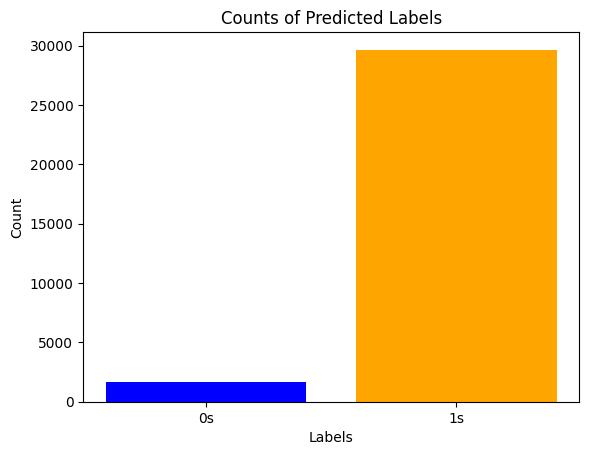

In [7]:
# probabilities = model_lgb.predict(x_train)
# threshold = min(probabilities[y_train == 1])

# # Convert probabilities to binary labels based on the threshold
# predicted_labels = (probabilities >= threshold).astype(int)
# clf_predicted_labels = predicted_labels.flatten().astype(int)


y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
threshold = min(y_pred[y_train == 1])
lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

bin_ploter(predicted_labels=lgb_predicted_labels)

In [8]:
# Policy-Network Model

class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        model = Sequential([
            Dense(64, input_shape=(input_dimension,)),  # Adjust `input_dimension` to match your feature count
            Activation('relu'),
            # Dense(256),
            # Activation('relu'),
            # Dense(128),
            # Activation('relu'),
            # Dense(64),
            # Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(16),
            Activation('relu'),
            Dense(1),  # Output layer for binary classification
            Activation('sigmoid')
        ])
        return model
    
    def get_model(self):
        return self.model
    
input_dimension = x_train.shape[1]
policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with one-hot encoded labels
# history_2 = pn_model.fit(x_train.to_numpy(), lgb_predicted_labels, epochs=60, batch_size=5, validation_split=0.2)
history_2 = pn_model.fit(x_train, lgb_predicted_labels, epochs=10, batch_size=128, validation_split=0.2)
pn_model.save_weights('pn_mlp_model_.weights.h5')
# pn_model.load_weights('pn_mlp_model_.weights.h5')

Epoch 1/10
196/196 [==============================] - 4s 14ms/step - loss: 0.0978 - accuracy: 0.9650 - val_loss: 0.0662 - val_accuracy: 0.9745
Epoch 2/10
196/196 [==============================] - 3s 13ms/step - loss: 0.0594 - accuracy: 0.9768 - val_loss: 0.0555 - val_accuracy: 0.9772
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 0.0554 - accuracy: 0.9783 - val_loss: 0.0628 - val_accuracy: 0.9753
Epoch 4/10
196/196 [==============================] - 5s 25ms/step - loss: 0.0499 - accuracy: 0.9794 - val_loss: 0.0490 - val_accuracy: 0.9794
Epoch 5/10
196/196 [==============================] - 5s 24ms/step - loss: 0.0448 - accuracy: 0.9823 - val_loss: 0.0533 - val_accuracy: 0.9777
Epoch 6/10
196/196 [==============================] - 5s 25ms/step - loss: 0.0394 - accuracy: 0.9834 - val_loss: 0.0467 - val_accuracy: 0.9789
Epoch 7/10
196/196 [==============================] - 5s 24ms/step - loss: 0.0378 - accuracy: 0.9849 - val_loss: 0.0519 - val_accuracy: 0.9786

980/980 [==============================] - 6s 6ms/step
Classifer predicted labels distribution: [ 1960 29387]


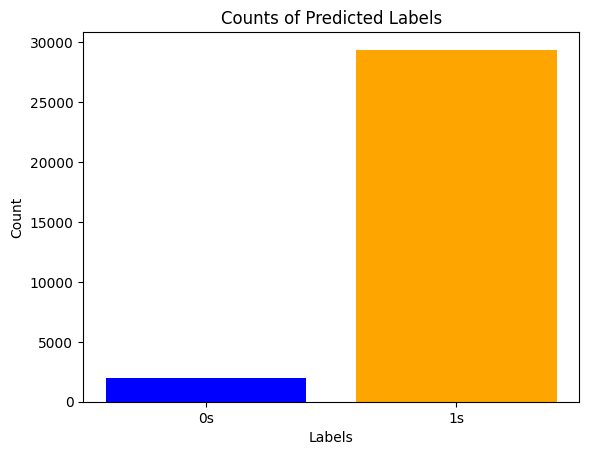

In [9]:
# probabilities = pn_model.predict(x_train.to_numpy())
probabilities = pn_model.predict(x_train)
threshold = min(probabilities[y_train == 1])

# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))
bin_ploter(predicted_labels=np_predicted_labels)

## Interactive learning

In [10]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    
    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states) 
        
        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # Ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # This should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()


        # actions = tf.cast(tf.random.uniform(tf.shape(probabilities)) < probabilities, tf.int32)
        # return actions.numpy(), probabilities.numpy()


    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # Calculate discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        # Updating policy
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Clear memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [11]:
# Clone policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[],
    'recall':[],
    'f1':[]
}

agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# Example parameters
n_epochs = 300
n_epochs = 10
batch_size = 128 # You can adjust the batch size as needed

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indices of positive examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify U0 - samples with predictions >= threshmin
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold
    # Positive examples above threshold or negative examples below threshold get positive rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  # Reward is the probability itself if conditions are met
        else:
            reward = prob -1  # Otherwise, reward is the complement of the probability
        rewards.append(reward)
    return rewards

In [13]:
# num_initial_round = 5
# model_lgb = lgb.train(params, train_data, num_boost_round=num_initial_round, valid_sets=[test_data])
# model_lgb.save_model('lgb_model.we7ights.h5')


# y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
# threshold = min(y_pred[y_train == 1])
# lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
# print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

In [14]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, model_lgb=model_lgb):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(len(y_train))
    # dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # lgb_probabilities=None
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)
            train_data = lgb.Dataset(x_batch, label=actions)
            valid_data = lgb.Dataset(x_batch, label=actions)
            model_lgb = lgb.train(params, train_data, num_boost_round=1, init_model=model_lgb, keep_training_booster=True)
    

            # Fit the model on the current batch and update history
            # batch_history = model.fit(x_batch, actions, epochs=1, batch_size=len(x_batch), validation_split=0.2)
            # history['batch_loss'].append(batch_history.history['loss'][0])
            # history['batch_accuracy'].append(batch_history.history['accuracy'][0])

            lgb_probabilities = model_lgb.predict(x_batch, num_iteration=model_lgb.best_iteration)
            threshold = calculate_threshold(lgb_probabilities, y_batch)
            rewards = calculate_rewards(lgb_probabilities, y_batch, threshold)

            # Store transitions and learn from them
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break

        y_pred_prob = model_lgb.predict(x_test)
        threshold = calculate_threshold(y_pred_prob, y_test)
        print(f"threshold: {threshold}")
        y_pred = np.where(y_pred_prob >= threshold, 1, 0)

        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("AUC-ROC:", roc_auc)
        history['ROC_AUC'].append(roc_auc)

        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)
        history['accuracy'].append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_pred_prob)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        print("Precision:", pr_auc)

        # conf_matrix = confusion_matrix(y_test, y_pred)
        # print("Confusion Matrix:")
        # print(conf_matrix)
        # Test the confustion matrix and test the inputs

        recall = recall_score(y_test, y_pred)
        print("Recall:", recall)
        history['recall'].append(recall)

        # Calculate F1 score
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        history['f1'].append(f1)


        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=y_train, model_lgb=model_lgb)

Epoch 1/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 26746, number of negative: 4601
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.037656 secs. 1 sparse feature groups
threshold: 0.13416390837508763
AUC-ROC: 0.9709253314846085
Accuracy: 0.8651
Precision: 0.9790826872867734
Recall: 0.7388648009459993
F1 Score: 0.8475189329716288
Updating target policy...
Epoch 2/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.042550 secs. 1 sparse feature groups
threshold: 0.13466084955346858
AUC-ROC: 0.9709262116774058
Accuracy: 0.8648
Precision: 0.9790986619002481
Recall: 0.7380764682696098
F1 Score: 0.8470934177787831
Epoch 3/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.039507 secs. 1 sparse feature groups
threshold: 0.1351867692336689
AUC-ROC: 0.9709672206600135
Accuracy: 0.8648
Precision: 0.979113273573479
Recall: 0.7382735514387071
F1 Score: 0.8471279963817278
Epoch 4/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.038890 secs. 1 sparse feature groups
threshold: 0.13569465940274728
AUC-ROC: 0.9709956668908757
Accuracy: 0.8653
Precision: 0.979140308173425
Recall: 0.7388648009459993
F1 Score: 0.8477105709440361
Updating target policy...
Epoch 5/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.041111 secs. 1 sparse feature groups
threshold: 0.13611802869864897
AUC-ROC: 0.9710671225425216
Accuracy: 0.865
Precision: 0.9791816801494633
Recall: 0.7382735514387071
F1 Score: 0.8473196109477493
Epoch 6/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.040964 secs. 1 sparse feature groups
threshold: 0.13659962595991895
AUC-ROC: 0.9712279977806337
Accuracy: 0.8654
Precision: 0.9792828769776747
Recall: 0.7390618841150965
F1 Score: 0.8478408320144698
Epoch 7/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.043306 secs. 1 sparse feature groups
threshold: 0.13702511284235344
AUC-ROC: 0.9713750299865682
Accuracy: 0.8653
Precision: 0.9793595712738132
Recall: 0.7388648009459993
F1 Score: 0.8477105709440361
Updating target policy...
Epoch 8/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.041677 secs. 1 sparse feature groups
threshold: 0.1374605261162266
AUC-ROC: 0.9714116780139522
Accuracy: 0.8652
Precision: 0.979378864348984
Recall: 0.7386677177769019
F1 Score: 0.8475802804161013
Epoch 9/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.046872 secs. 1 sparse feature groups
threshold: 0.13791013760524384
AUC-ROC: 0.9714590483899594
Accuracy: 0.8652
Precision: 0.9794191626746691
Recall: 0.7386677177769019
F1 Score: 0.8475802804161013
Epoch 10/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.046010 secs. 1 sparse feature groups
threshold: 0.1383073165798565
AUC-ROC: 0.9715008575478373
Accuracy: 0.8647
Precision: 0.9794250444170858
Recall: 0.7378793851005124
F1 Score: 0.8469630132337971
Updating target policy...
Epoch 11/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.045361 secs. 1 sparse feature groups
threshold: 0.13879220154988742
AUC-ROC: 0.9715859161790799
Accuracy: 0.8653
Precision: 0.979468627446574
Recall: 0.7390618841150965
F1 Score: 0.84774499830451
Epoch 12/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047201 secs. 1 sparse feature groups
threshold: 0.13919868557208864
AUC-ROC: 0.9715948381333448
Accuracy: 0.8653
Precision: 0.9794755974346463
Recall: 0.7388648009459993
F1 Score: 0.8477105709440361
Epoch 13/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.046912 secs. 1 sparse feature groups
threshold: 0.13956332623644527
AUC-ROC: 0.9717408701201911
Accuracy: 0.8656
Precision: 0.9795391162219291
Recall: 0.7396531336223886
F1 Score: 0.8481355932203389
Updating target policy...
Epoch 14/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047464 secs. 1 sparse feature groups
threshold: 0.14000087349494675
AUC-ROC: 0.971727387166885
Accuracy: 0.8652
Precision: 0.9795352395505472
Recall: 0.7390618841150965
F1 Score: 0.8476491862567812
Epoch 15/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.044983 secs. 1 sparse feature groups
threshold: 0.14038488296384816
AUC-ROC: 0.971882861221922
Accuracy: 0.8655
Precision: 0.9796146453126876
Recall: 0.7396531336223886
F1 Score: 0.8480397695175687
Epoch 16/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047707 secs. 1 sparse feature groups
threshold: 0.1408283718976191
AUC-ROC: 0.971978802236842
Accuracy: 0.866
Precision: 0.979674278667551
Recall: 0.740441466298778
F1 Score: 0.8486559747007002
Updating target policy...
Epoch 17/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.050085 secs. 1 sparse feature groups
threshold: 0.14117834240698307
AUC-ROC: 0.9720523783529544
Accuracy: 0.8658
Precision: 0.9797185387485096
Recall: 0.7406385494678754
F1 Score: 0.8484985324000903
Epoch 18/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.048770 secs. 1 sparse feature groups
threshold: 0.14158338988853622
AUC-ROC: 0.9720166905358951
Accuracy: 0.8659
Precision: 0.9797012682282185
Recall: 0.7406385494678754
F1 Score: 0.8485943321666478
Epoch 19/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.049553 secs. 1 sparse feature groups
threshold: 0.14189864173475542
AUC-ROC: 0.9722387391734286
Accuracy: 0.8664
Precision: 0.9798329520074066
Recall: 0.7416239653133623
F1 Score: 0.8492439629880388
Updating target policy...
Epoch 20/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.046332 secs. 1 sparse feature groups
threshold: 0.14235012041913006
AUC-ROC: 0.9722567031082487
Accuracy: 0.8661
Precision: 0.9798455196818595
Recall: 0.7408356326369728
F1 Score: 0.8488201422603591
Epoch 21/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.052015 secs. 1 sparse feature groups
threshold: 0.1426859027729494
AUC-ROC: 0.9725895560163498
Accuracy: 0.866
Precision: 0.9800229844283151
Recall: 0.7406385494678754
F1 Score: 0.8486901535682023
Epoch 22/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.049112 secs. 1 sparse feature groups
threshold: 0.14306962717331514
AUC-ROC: 0.9726204827905505
Accuracy: 0.8658
Precision: 0.9800453699717289
Recall: 0.7402443831296808
F1 Score: 0.8484300880957759
Updating target policy...
Epoch 23/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.050614 secs. 1 sparse feature groups
threshold: 0.14351131838539805
AUC-ROC: 0.9728475525279057
Accuracy: 0.8662
Precision: 0.9801733587447984
Recall: 0.7406385494678754
F1 Score: 0.8488818613056246
Epoch 24/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.050223 secs. 1 sparse feature groups
threshold: 0.14398474683178056
AUC-ROC: 0.9732176735992253
Accuracy: 0.866
Precision: 0.980395553551429
Recall: 0.7406385494678754
F1 Score: 0.8486901535682023
Epoch 25/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.050204 secs. 1 sparse feature groups
threshold: 0.14442607036124963
AUC-ROC: 0.9731871469126597
Accuracy: 0.8665
Precision: 0.9803765255158466
Recall: 0.7414268821442649
F1 Score: 0.8493057907213004
Updating target policy...
Epoch 26/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.049140 secs. 1 sparse feature groups
threshold: 0.14484793043121802
AUC-ROC: 0.9732246351240774
Accuracy: 0.8662
Precision: 0.9804036937104683
Recall: 0.7410327158060701
F1 Score: 0.8489501016030707
Epoch 27/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.045388 secs. 1 sparse feature groups
threshold: 0.14521096167192057
AUC-ROC: 0.9731860266672812
Accuracy: 0.8663
Precision: 0.980379607031435
Recall: 0.7412297989751675
F1 Score: 0.8490800316062761
Epoch 28/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047915 secs. 1 sparse feature groups
threshold: 0.1457385481223471
AUC-ROC: 0.9735208200004128
Accuracy: 0.8662
Precision: 0.9805781622932764
Recall: 0.7412297989751675
F1 Score: 0.8489841986455982
Updating target policy...
Epoch 29/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.052184 secs. 1 sparse feature groups
threshold: 0.14609916174609064
AUC-ROC: 0.9738787584032407
Accuracy: 0.8662
Precision: 0.980774201967245
Recall: 0.7410327158060701
F1 Score: 0.8489501016030707
Epoch 30/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.048267 secs. 1 sparse feature groups
threshold: 0.14648242273605228
AUC-ROC: 0.974095745932189
Accuracy: 0.8663
Precision: 0.9809127715650134
Recall: 0.7410327158060701
F1 Score: 0.8490459523540702
Epoch 31/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.050264 secs. 1 sparse feature groups
threshold: 0.1468334405719762
AUC-ROC: 0.9742155721789302
Accuracy: 0.8665
Precision: 0.9809661029562897
Recall: 0.7414268821442649
F1 Score: 0.8493057907213004
Updating target policy...
Epoch 32/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.050029 secs. 1 sparse feature groups
threshold: 0.14723016906232875
AUC-ROC: 0.9742467390057119
Accuracy: 0.8666
Precision: 0.9809775545947406
Recall: 0.7416239653133623
F1 Score: 0.8494356659142213
Epoch 33/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047011 secs. 1 sparse feature groups
threshold: 0.14760617541790896
AUC-ROC: 0.9743933711240109
Accuracy: 0.8664
Precision: 0.9810699109971427
Recall: 0.7412297989751675
F1 Score: 0.8491758862045609
Epoch 34/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.045445 secs. 1 sparse feature groups
threshold: 0.1479586613761259
AUC-ROC: 0.9745703298850579
Accuracy: 0.8666
Precision: 0.9811963978801274
Recall: 0.7414268821442649
F1 Score: 0.849401670806051
Updating target policy...
Epoch 35/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.048052 secs. 1 sparse feature groups
threshold: 0.14837351986457936
AUC-ROC: 0.9745908943895071
Accuracy: 0.8664
Precision: 0.9812082740630148
Recall: 0.7410327158060701
F1 Score: 0.8491418247515808
Epoch 36/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047969 secs. 1 sparse feature groups
threshold: 0.14867019289934083
AUC-ROC: 0.9746315232888612
Accuracy: 0.8669
Precision: 0.9812416123437315
Recall: 0.742018131651557
F1 Score: 0.8497912199526013
Epoch 37/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047046 secs. 1 sparse feature groups
threshold: 0.14897313597058381
AUC-ROC: 0.9746550884505742
Accuracy: 0.867
Precision: 0.9812718441401811
Recall: 0.7422152148206543
F1 Score: 0.8499210110584519
Updating target policy...
Epoch 38/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.043978 secs. 1 sparse feature groups
threshold: 0.14935692749508703
AUC-ROC: 0.9748740564133167
Accuracy: 0.8674
Precision: 0.9814025709094254
Recall: 0.7428064643279464
F1 Score: 0.8504061371841155
Epoch 39/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.046689 secs. 1 sparse feature groups
threshold: 0.14970268780996177
AUC-ROC: 0.9748689352915862
Accuracy: 0.8668
Precision: 0.9814066673028955
Recall: 0.7416239653133623
F1 Score: 0.8496274554075413
Epoch 40/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.046707 secs. 1 sparse feature groups
threshold: 0.1501010137985013
AUC-ROC: 0.9749404709607592
Accuracy: 0.8668
Precision: 0.9814694851412951
Recall: 0.7418210484824596
F1 Score: 0.8496613995485327
Updating target policy...
Epoch 41/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.076870 secs. 1 sparse feature groups
threshold: 0.15043686106529425
AUC-ROC: 0.9749190062591311
Accuracy: 0.8669
Precision: 0.9814581562767947
Recall: 0.7418210484824596
F1 Score: 0.8497573089513489
Epoch 42/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.044891 secs. 1 sparse feature groups
threshold: 0.15079205275290294
AUC-ROC: 0.9749458521394526
Accuracy: 0.8672
Precision: 0.9814778006435327
Recall: 0.7424122979897517
F1 Score: 0.8501466937485895
Epoch 43/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.045825 secs. 1 sparse feature groups
threshold: 0.1511047908592624
AUC-ROC: 0.9751578985861064
Accuracy: 0.8678
Precision: 0.9816119723919892
Recall: 0.7433977138352384
F1 Score: 0.8508910444394315
Updating target policy...
Epoch 44/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.043855 secs. 1 sparse feature groups
threshold: 0.15145631856332825
AUC-ROC: 0.9752361757319323
Accuracy: 0.8677
Precision: 0.9816724404235465
Recall: 0.7433977138352384
F1 Score: 0.8507950828916206
Epoch 45/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047047 secs. 1 sparse feature groups
threshold: 0.15177720710265025
AUC-ROC: 0.9752745841449112
Accuracy: 0.868
Precision: 0.9816958897688971
Recall: 0.7437918801734332
F1 Score: 0.851150202976996
Epoch 46/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 980, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99557
[LightGBM] [Info] Number of data points in the train set: 31347, number of used features: 587
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.049144 secs. 1 sparse feature groups


ResourceExhaustedError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[64,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

In [15]:
import pickle
with open('history_XGB.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_XGB.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

{'epoch_loss': [], 'epoch_accuracy': [], 'batch_loss': [], 'batch_accuracy': [], 'predictions': [], 'rewards': [], 'thresholds': [], 'ROC_AUC': [0.9709253314846085, 0.9709262116774058, 0.9709672206600135, 0.9709956668908757, 0.9710671225425216, 0.9712279977806337, 0.9713750299865682, 0.9714116780139522, 0.9714590483899594, 0.9715008575478373, 0.9715859161790799, 0.9715948381333448, 0.9717408701201911, 0.971727387166885, 0.971882861221922, 0.971978802236842, 0.9720523783529544, 0.9720166905358951, 0.9722387391734286, 0.9722567031082487, 0.9725895560163498, 0.9726204827905505, 0.9728475525279057, 0.9732176735992253, 0.9731871469126597, 0.9732246351240774, 0.9731860266672812, 0.9735208200004128, 0.9738787584032407, 0.974095745932189, 0.9742155721789302, 0.9742467390057119, 0.9743933711240109, 0.9745703298850579, 0.9745908943895071, 0.9746315232888612, 0.9746550884505742, 0.9748740564133167, 0.9748689352915862, 0.9749404709607592, 0.9749190062591311, 0.9749458521394526, 0.9751578985861064,

In [16]:
# import matplotlib.pyplot as plt

# # Plotting epoch losses and accuracies
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history['batch_loss'], label='Loss')
# plt.title('Epoch Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['batch_accuracy'], label='Accuracy')
# plt.title('Epoch Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# # You can add more plots for batch-level data, rewards, thresholds, etc.


# Visual

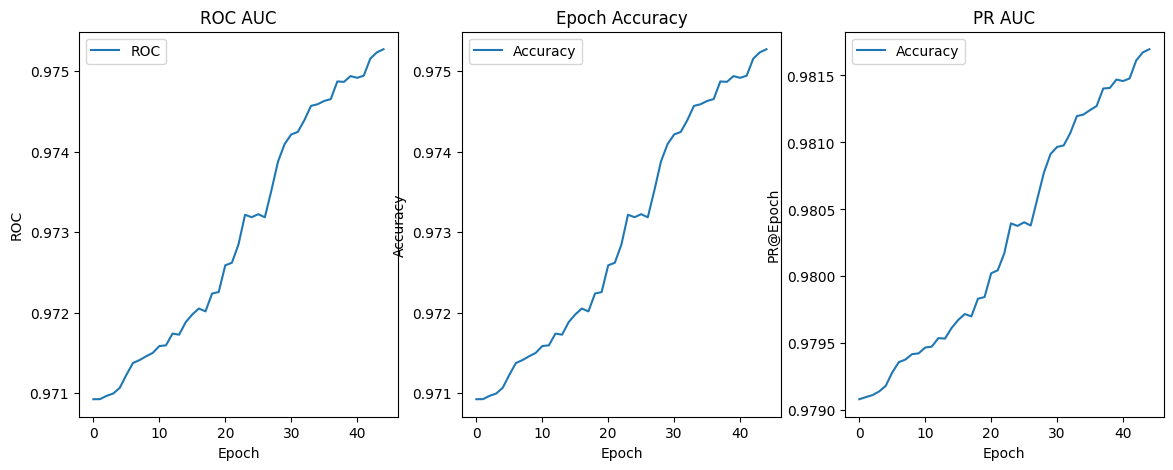

In [17]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='ROC')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='Accuracy')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()    

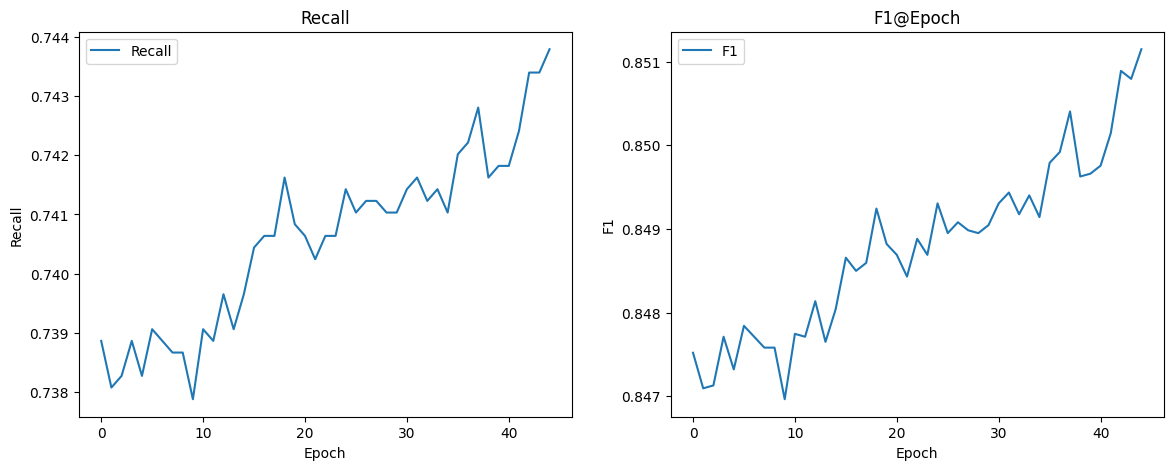

In [18]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['recall'], label='Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['f1'], label='F1')
plt.title('F1@Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(history['PR_AUC'], label='Accuracy')
# plt.title('PR AUC')
# plt.xlabel('Epoch')
# plt.ylabel('PR@Epoch')
# plt.legend()